In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import gaussian_kde  
from imblearn.over_sampling import SMOTE
import pickle

# Define crop dictionary for manual label mapping
crop_dict = {
    'rice': 1,
    'maize': 2,
    'jute': 3,
    'cotton': 4,
    'coconut': 5,
    'papaya': 6,
    'orange': 7,
    'apple': 8,
    'muskmelon': 9,
    'watermelon': 10,
    'grapes': 11,
    'mango': 12,
    'banana': 13,
    'pomegranate': 14,
    'lentil': 15,
    'blackgram': 16,
    'mungbean': 17,
    'mothbeans': 18,
    'pigeonpeas': 19,
    'kidneybeans': 20,
    'chickpea': 21,
    'coffee': 22
}

# Load Data
crop = pd.read_csv("Crop_recommendation.csv")

# Map string labels to numerical values
crop['label'] = crop['label'].map(crop_dict)

## Exploratory Data Analysis (EDA)

In [30]:
# Exploratory Data Analysis (EDA)
print("Dataset Shape:", crop.shape)
print("\nDataset Info:")
crop.info()
print("\nMissing Values:\n", crop.isnull().sum())
print("\nDuplicate Rows:", crop.duplicated().sum())
print("\nSummary Statistics:\n", crop.describe())

# Debug: Check unique labels after mapping
print("\nUnique Labels in Dataset (after mapping):\n", crop['label'].unique())

Dataset Shape: (2200, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 137.6 KB

Missing Values:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Duplicate Rows: 0

Summary Statistics:
                  N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.3

Available columns in the dataset:
['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

Features we'll analyze:
['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


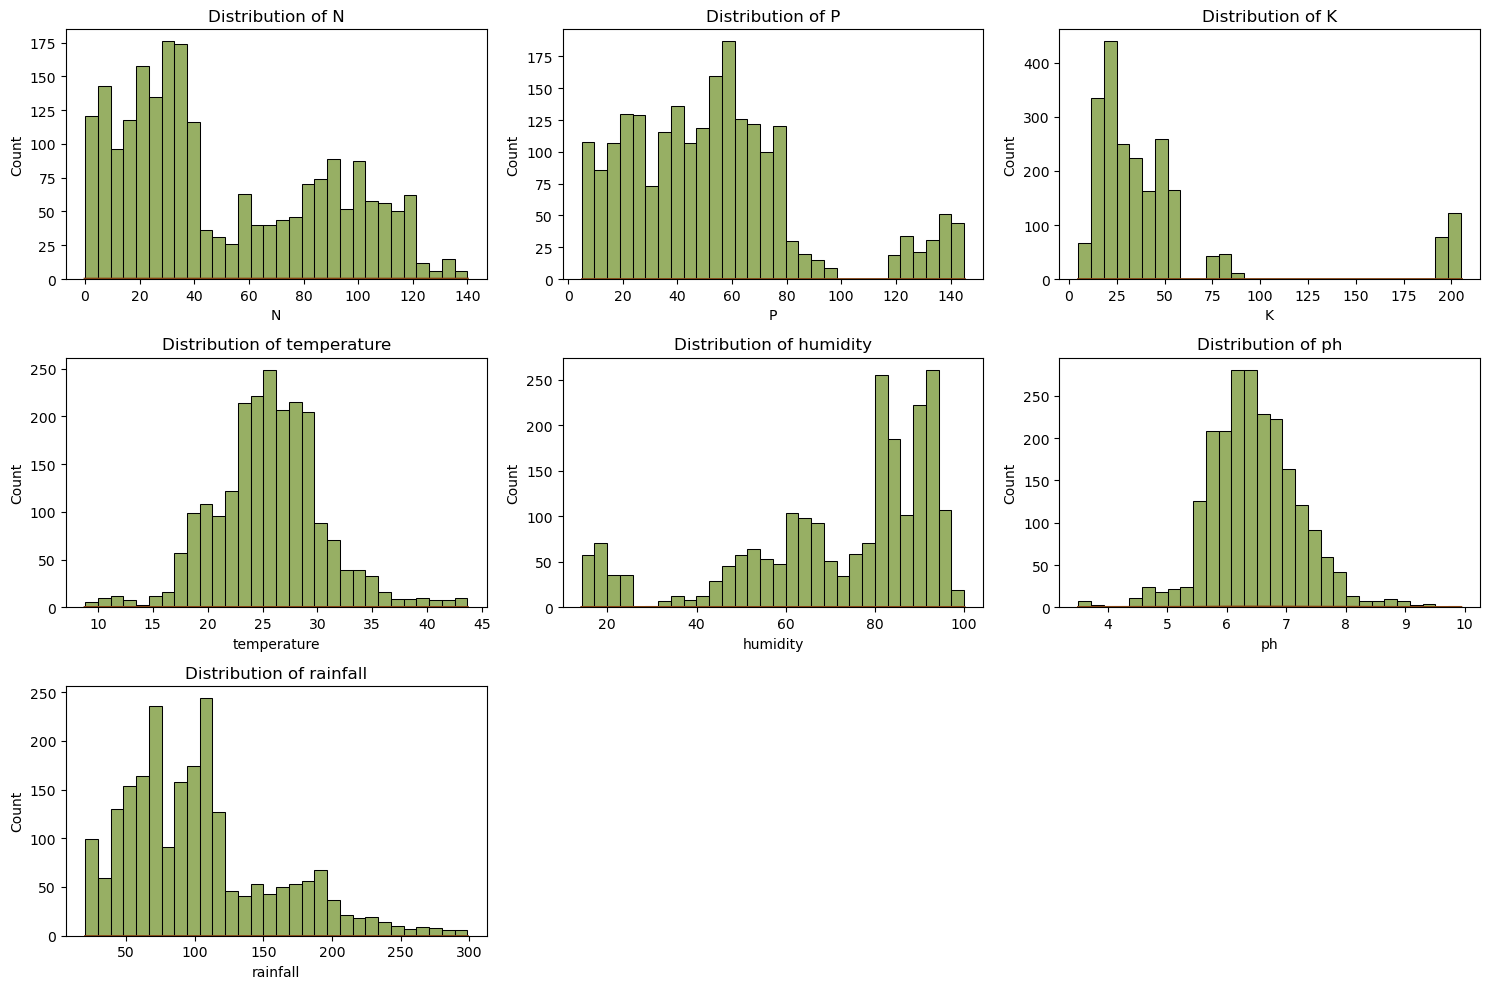

In [31]:
# First, let's see what columns are actually available
print("Available columns in the dataset:")
print(crop.columns.tolist())

# Adjust the features list based on actual columns
features = [col for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'] 
            if col in crop.columns]

print("\nFeatures we'll analyze:")
print(features)

# Now proceed with the visualization
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    data = np.array(crop[feature]).flatten()
    
    # Histogram
    sns.histplot(data, bins=30, kde=False, color='#6B8E23', alpha=0.7)
    
    # Manual KDE
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    plt.plot(x_grid, kde(x_grid), color='#8B4513', linewidth=2)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

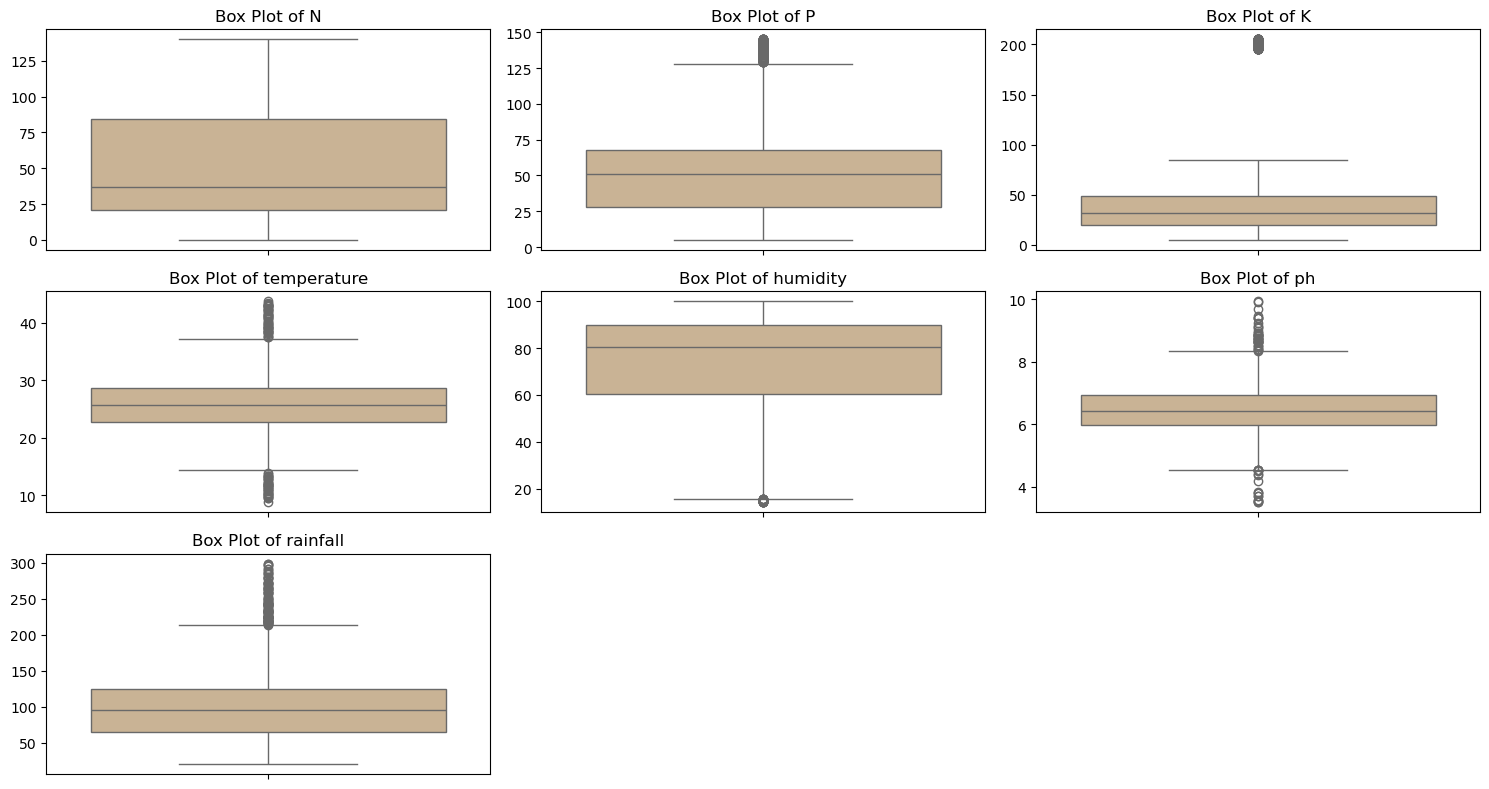

In [32]:
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=np.array(crop[feature]).flatten(), color='#D2B48C')
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

## Preprocessing

In [33]:
# Drop 'rainfall' (assuming domain knowledge justifies this; otherwise, analyze feature importance)
crop = crop.drop('rainfall', axis=1)

# Correlation Analysis
numeric_crop = crop.select_dtypes(include=['number'])
print("\nCorrelation Matrix:\n", numeric_crop.corr())

# Prepare features and target
X = crop.drop('label', axis=1)
y = crop['label']

# Encode labels (optional, since already numerical, but kept for consistency)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Debug: Check LabelEncoder classes
print("\nLabelEncoder Classes:", le.classes_)
print("Type of LabelEncoder Classes:", type(le.classes_[0]))


Correlation Matrix:
                     N         P         K  temperature  humidity        ph  \
N            1.000000 -0.231460 -0.140512     0.026504  0.190688  0.096683   
P           -0.231460  1.000000  0.736232    -0.127541 -0.118734 -0.138019   
K           -0.140512  0.736232  1.000000    -0.160387  0.190859 -0.169503   
temperature  0.026504 -0.127541 -0.160387     1.000000  0.205320 -0.017795   
humidity     0.190688 -0.118734  0.190859     0.205320  1.000000 -0.008483   
ph           0.096683 -0.138019 -0.169503    -0.017795 -0.008483  1.000000   
label       -0.317076  0.109993 -0.089209    -0.031383 -0.640925  0.057527   

                label  
N           -0.317076  
P            0.109993  
K           -0.089209  
temperature -0.031383  
humidity    -0.640925  
ph           0.057527  
label        1.000000  

LabelEncoder Classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Type of LabelEncoder Classes: <class 'numpy.int64'>


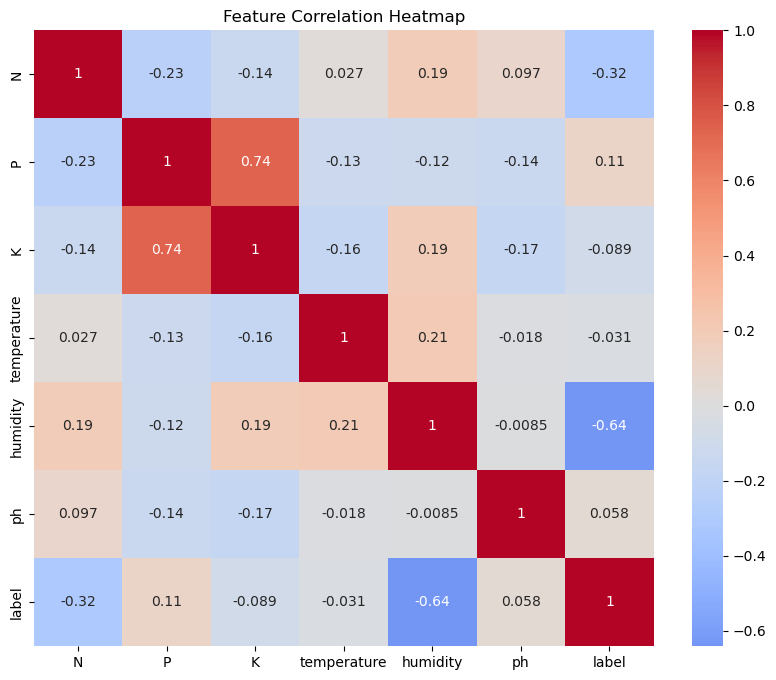

In [35]:
# Calculate correlation matrix
corr = numeric_crop.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

## Model Training

In [36]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features using StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Initialize RandomForestClassifier
randclf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=randclf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
randclf = grid_search.best_estimator_
print("\nBest Parameters from GridSearchCV:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Cross-validation scores
cv_scores = cross_val_score(randclf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation CV Score:", cv_scores.std())


Best Parameters from GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.9670454545454547

Cross-Validation Scores: [0.96875    0.96022727 0.96590909 0.97159091 0.96875   ]
Mean CV Score: 0.9670454545454547
Standard Deviation CV Score: 0.003853596581321173


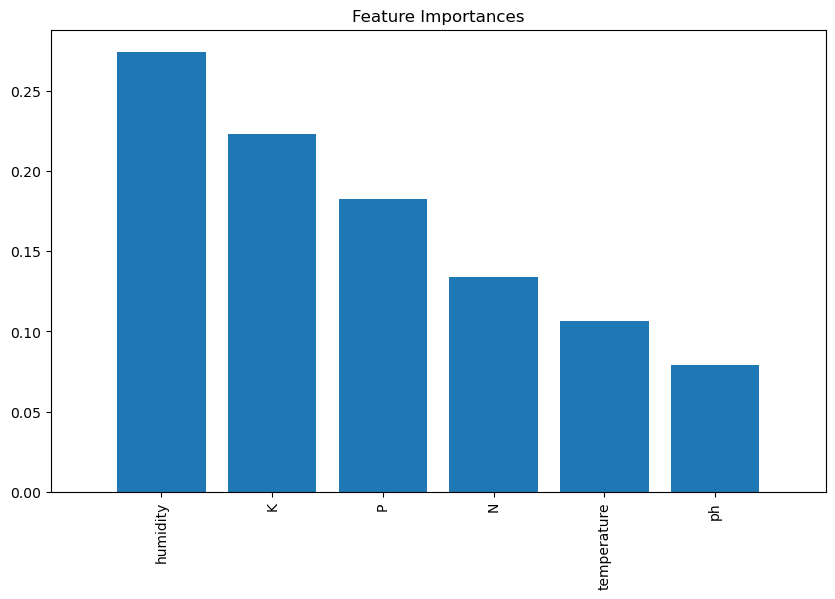

In [38]:
# Get feature importances
importances = randclf.feature_importances_
feature_names = X.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


## Model Evaluation


Crop Labels for Confusion Matrix: ['rice', 'maize', 'jute', 'cotton', 'coconut', 'papaya', 'orange', 'apple', 'muskmelon', 'watermelon', 'grapes', 'mango', 'banana', 'pomegranate', 'lentil', 'blackgram', 'mungbean', 'mothbeans', 'pigeonpeas', 'kidneybeans', 'chickpea', 'coffee']


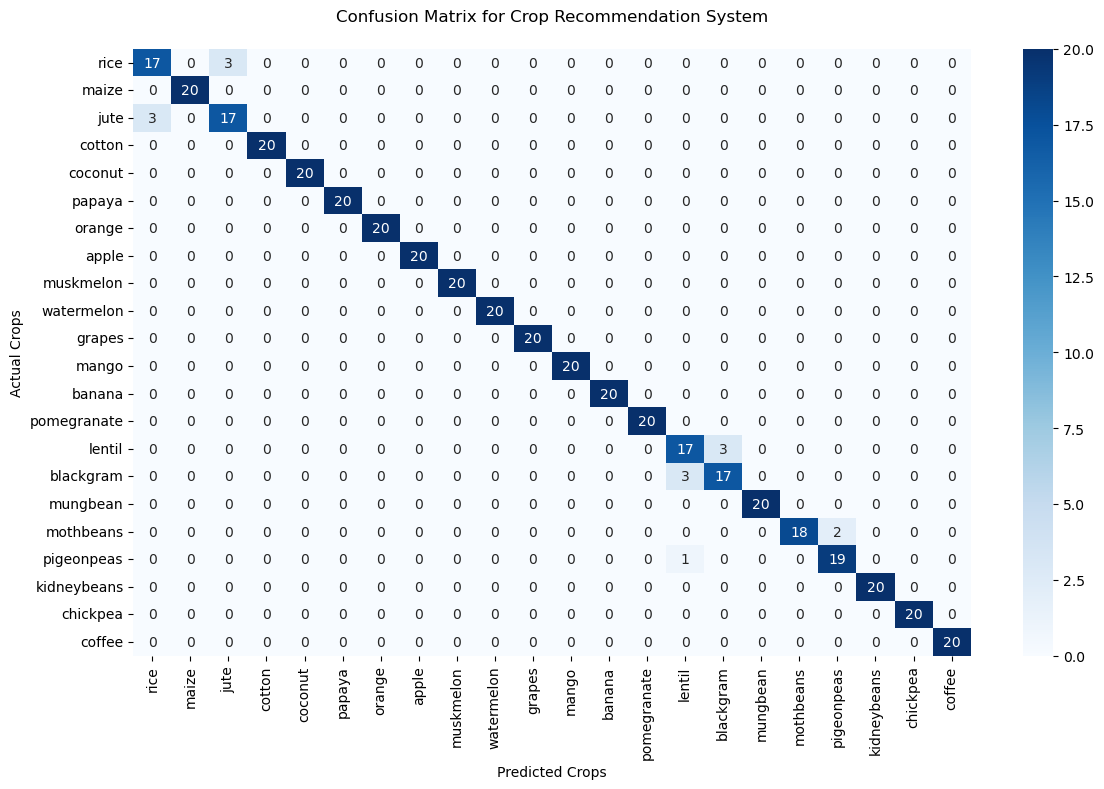


Classification Report:
               precision    recall  f1-score   support

        rice       0.85      0.85      0.85        20
       maize       1.00      1.00      1.00        20
        jute       0.85      0.85      0.85        20
      cotton       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      papaya       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20
       apple       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
  watermelon       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
 pomegranate       1.00      1.00      1.00        20
      lentil       0.81      0.85      0.83        20
   blackgram       0.85      0.85      0.85        20
    mungbean       1.00      1.00      1.00        20
  

In [37]:
# Evaluate on test set
y_pred = randclf.predict(X_test_scaled)

# Confusion Matrix
crop_labels = list(crop_dict.keys())  # Use crop_dict keys for string labels
print("\nCrop Labels for Confusion Matrix:", crop_labels)  # Debug: Verify labels
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=crop_labels, yticklabels=crop_labels)
plt.title('Confusion Matrix for Crop Recommendation System', pad=20)
plt.xlabel('Predicted Crops')
plt.ylabel('Actual Crops')
plt.tight_layout()
plt.show()

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=crop_labels))

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': randclf.feature_importances_})
print("\nFeature Importance:\n", feature_importance.sort_values(by='Importance', ascending=False))

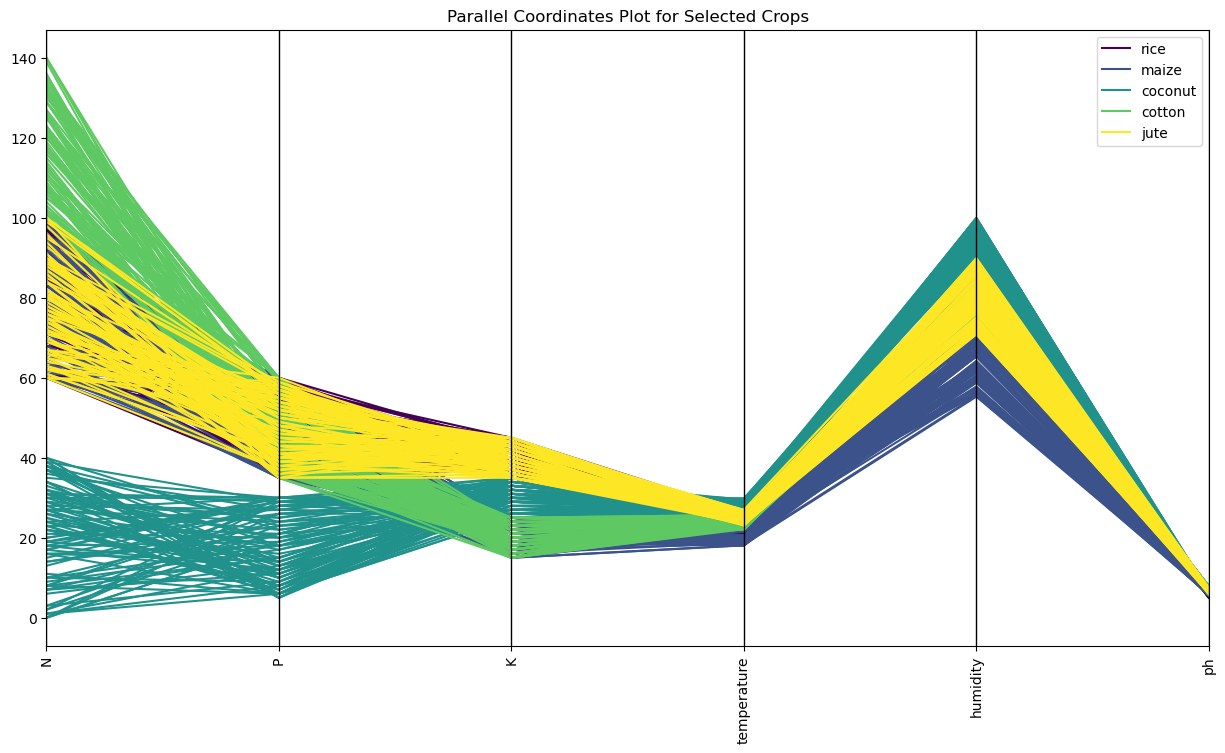

In [41]:
from pandas.plotting import parallel_coordinates

# Select a sample of crops
sample_crops = crop[crop['label'].isin([1, 2, 3, 4, 5])].copy()

# Convert numerical labels back to names for visualization
sample_crops['label'] = sample_crops['label'].map({v:k for k,v in crop_dict.items()})

plt.figure(figsize=(15, 8))
parallel_coordinates(sample_crops, 'label', colormap='viridis')
plt.title('Parallel Coordinates Plot for Selected Crops')
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Recommendation Function

In [ ]:
# Recommendation Function (returns crop name as string)
def recommendation(N, P, K, temperature, humidity, ph):
    features = np.array([[N, P, K, temperature, humidity, ph]])
    print(f"Raw features: {features}")
    
    sc_features = sc.transform(features)
    print(f"After StandardScaler: {sc_features}")
    
    prediction = randclf.predict(sc_features)
    print(f"Raw prediction: {prediction}")
    
    # Convert numerical prediction to crop name using crop_dict
    inv_crop_dict = {v: k for k, v in crop_dict.items()}  # Inverse mapping
    return inv_crop_dict[le.inverse_transform(prediction)[0]]

## Test Recommendation

In [ ]:
N = 90
P = 42
K = 43
temperature = 20.879744
humidity = 82.002744
ph = 6.502985
predict = recommendation(N, P, K, temperature, humidity, ph)
print("\nPredicted Crop:", predict)

Raw features: [[90.       42.       43.       20.879744 82.002744  6.502985]]
After StandardScaler: [[ 1.06518409 -0.34114083 -0.10176167 -0.93156787  0.47125037  0.05037982]]
Raw prediction: [0]

Predicted Crop: rice


/home/teddy/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Save the Model and Scalers

In [ ]:
# pickle.dump(randclf, open('model.pkl', 'wb'))
# pickle.dump(sc, open('standscaler.pkl', 'wb'))
# pickle.dump(le, open('labelencoder.pkl', 'wb'))